In [1]:
from qiskit.quantum_info import Statevector
from qiskit.visualization.bloch import Bloch
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile
from sympy.physics.matrices import msigma
from sympy import N, re, im, I, E, symbols
from numpy import pi
import numpy as np
import math, sys



In [2]:
Aer.backends()
simulator = Aer.get_backend('aer_simulator')
qreg_q = QuantumRegister(1, 'q')
circuit = QuantumCircuit(qreg_q)
clreg = ClassicalRegister(1)

In [3]:
def get_angles(vec):

    cos_θ_rotated = float(N(re(vec[0,0])))
    θ_rotated = np.arccos(cos_θ_rotated) # Not enough to allow full rotation

    #e^(ix) = cos(x) + i*sin(x), see https://en.wikipedia.org/wiki/Euler%27s_identity
    temp = float(N(re(vec[1,0])))
    temp = temp/np.sin(θ_rotated)
    ϕ_rotated = np.arccos(temp)

    return(ϕ_rotated,θ_rotated)

def to_spherical(vec):
    x = np.real(vec[0])
    y = np.real(vec[1])
    z = np.real(vec[2])
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    ϕ = np.arctan2(y, x) #az
    θ = np.arctan2(z, hxy) #el
    return [r, ϕ, θ]

def to_cartesian(polar):
    r = polar[0]
    ϕ = polar[1]
    θ = polar[2]
    x = r * np.sin(θ) * np.cos(ϕ)
    y = r * np.sin(θ) * np.sin(ϕ)
    z = r * np.cos(θ)
    return [np.real(x), np.real(y), np.real(z)]

#Pauli basis
sx = msigma(1)
sy = msigma(2)
sz = msigma(3)

In [4]:
"""
Use of Operator-class: https://qiskit.org/documentation/tutorials/circuits_advanced/02_operators_overview.html#Operator-Class

# Matrix taken from
# https://docplayer.org/117986458-Die-symmetriegruppen-so-3-und-su-2.html (p. 11, equation 46)
# https://www.uni-muenster.de/Physik.TP/archive/fileadmin/lehre/teilchen/ws1011/SO3SU2.pdf (p. 8, equation 50)

def rn_su2(theta, n):
    
    if not math.isclose(np.linalg.norm(n), 1, rel_tol = 0.000001):
        print("Magnitude of n must be 1!")
        return None

    n1 = n[0]
    n2 = n[1]
    n3 = n[2]

    return Operator([
        [np.cos(theta/2) - 1j*n3*np.sin(theta/2), -1j*(n1 - 1j*n2)*np.sin(theta/2)],
        [-1j*(n1 + 1j*n2)*np.sin(theta/2), np.cos(theta/2) + 1j*n3*np.sin(theta/2)]
    ], input_dims=(2, 1), output_dims=(2, 1))


"""

'\nUse of Operator-class: https://qiskit.org/documentation/tutorials/circuits_advanced/02_operators_overview.html#Operator-Class\n\n# Matrix taken from\n# https://docplayer.org/117986458-Die-symmetriegruppen-so-3-und-su-2.html (p. 11, equation 46)\n# https://www.uni-muenster.de/Physik.TP/archive/fileadmin/lehre/teilchen/ws1011/SO3SU2.pdf (p. 8, equation 50)\n\ndef rn_su2(theta, n):\n    \n    if not math.isclose(np.linalg.norm(n), 1, rel_tol = 0.000001):\n        print("Magnitude of n must be 1!")\n        return None\n\n    n1 = n[0]\n    n2 = n[1]\n    n3 = n[2]\n\n    return Operator([\n        [np.cos(theta/2) - 1j*n3*np.sin(theta/2), -1j*(n1 - 1j*n2)*np.sin(theta/2)],\n        [-1j*(n1 + 1j*n2)*np.sin(theta/2), np.cos(theta/2) + 1j*n3*np.sin(theta/2)]\n    ], input_dims=(2, 1), output_dims=(2, 1))\n\n\n'

In [5]:

# Magnitude of the vector n must be 1
#n = [1, 0, 0]
#n = [1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)]

# Debug: check if the matrix is unitary
#mat = np.array(rn_su2(pi, n))
# Compute A^dagger.A and see if it is identity matrix
#mat = np.conj(mat.T).dot(mat)
#print(mat)

    #rot_operator = rn_su2(rot_angle, n)
    #rot_matrix = np.array(rot_operator)
    #M_q_rotated = rot_matrix*M_q*np.matrix(rot_matrix).H

In [6]:
# https://www.phys.hawaii.edu/~yepez/Spring2013/lectures/Lecture1_Qubits_Notes.pdf (p. 3)

def sU2(rot_angle,vec,n):

    if not math.isclose(np.linalg.norm(n), 1, rel_tol = 0.000001):
        sys.exit("Magnitude of n must be 1!") 
    
    #from cartesian coordinates to spherical (Kugelkoordinaten)
    spherical_vec = to_spherical(vec)
    ϕ = spherical_vec[1]
    θ = spherical_vec[2]

    
    #Qubit rotation by angle
    M_q = (np.sin(θ)*np.cos(ϕ)*sx + np.sin(θ)*np.sin(ϕ)*sy + np.cos(θ)*sz)
    #unitary matrix
    U_n = np.eye(2)*np.cos(rot_angle/2) -1j*(n[0]*sx+n[1]*sy+n[2]*sz)*np.sin(rot_angle/2)
    #Qubit rotation by angle
    vec = U_n*M_q*np.matrix(U_n).H

    #U_n * M_q * complex conjugate U_n (26 of Hawaii-sheet)

    (ϕ_rotated, θ_rotated) = get_angles(vec)
   
    #from spherical coordinates to cartesian
    M_q_rotated = np.array(to_cartesian([1, θ_rotated, ϕ_rotated]))

    return M_q_rotated
    

[1, 0, 0]
[8.09016994e-01 5.87785252e-01 6.12323400e-17]
[8.09016994e-01 5.87785252e-01 6.12323400e-17]
[8.09016994e-01 5.87785252e-01 6.12323400e-17]
[8.09016994e-01 5.87785252e-01 6.12323400e-17]
[8.09016994e-01 5.87785252e-01 6.12323400e-17]


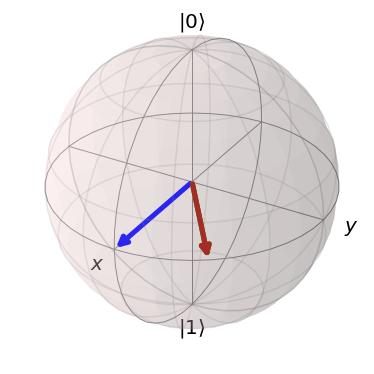

In [7]:
#rotation angle
rot_angle1 = pi/2   # x
rot_angle2 = pi/4   # y
rot_angle3 = 2*pi/10# z

#rotation axis
n1 = [1, 0, 0] # x
n2 = [0, 1, 0] # y
n3 = [0, 0, 1] # z

#startvector
start_vec = [1, 0, 0]
#            x  y  z

#number of rotations
nOr = 6

_bloch = Bloch()
_bloch.vector_color = ['blue', 'red', 'orange','yellow', 'green', 'brown']*2

sv = []
vec = start_vec
sv.append(vec)
print(vec)

for i in range(1,nOr):

    #vec = sU2(i*rot_angle1,vec,n1)
    #vec = sU2(i*rot_angle2,vec,n2)
    vec = sU2(rot_angle3,vec,n3)

    print(vec)

    sv.append(vec)
    
_bloch.add_vectors(sv)
_bloch.render()